# Facial Recognition and PCA Lab 

This lab demonstrates how dimensionality reduction techniques such as Principal Component Analysis (PCA) can be used for facial recognition. The code within this notebook is modularized into smaller functions to provide for a more generalized approach to change certain parameters. For example, one could easily change the split of datasets, basis set, and thus run multiple test to find optimal parameters. Each method provides a description of its function, its inputs, and its outputs. The lab has two trails, Part A and Part C, used to compare results when the user changes the split of images for the three different datasets. Part B demonstrates how the importance on the number of feature eigenfaces and its effect on accuracy. 

## Read Images Into Program 

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

#External library pillow is an image library 
#that has pgm support
from PIL import Image

def readImages():
    
    """
    This function reads in the images from the att Database of faces. 
    The images are organized in 40 folders for 40 participants with 
    10 pictures per participant. The image array is then reshaped into a matrix 
    with size 112*92x400 and converted to a float. The function outputs 
    the main image matrix 
    """
    
    #Read in images and format into matrix of size 10304x400

    #allocate image array to desired output size of 10304x400
    img_arr = np.zeros([10304, 400])

    #initialize iterator 
    k = 0

    #loop through number of participants (folders) 1-40
    for i in range(1, len(os.listdir('att_faces'))):
        #loop through individual images per participant 1-10
        for j in range(1, len(os.listdir('att_faces/s'+str(i)))+1):

            #save images to variable 
            images = 'att_faces/s'+str(i)+'/'+str(j)+'.pgm'

            #load image into PIL imager 
            img = Image.open(images)

            #assigned temp image to temporary numpy array 
            temp = np.array(img)

            #reshapre image to desired output size 10304x400
            img_arr[:,k] = np.reshape(temp, (temp.shape[0] * temp.shape[1]))

            #update iterator 
            k += 1
    return img_arr.astype(float)

## Separating Out the Datasets

In [2]:
#Split datasets
def splitData(image_array, test_start, train_start, gallery_start):
    
    """
    splitData splits the main image matrix, img_arr, into test, train, and gallery datasets. 
    splitData takes in the main image array and start locations for the training, testing, 
    and gallery datasets. This functionality allows the method to be more generalized and 
    allows the user to split the dataset different ways to compare results. The function 
    then outputs the three split datasets, test_set, train_set, and gallery_set. 
    """

    # create arrays of size 10304xnum of cols for each set 
    test_set = np.zeros([10304,80])
    train_set = np.zeros([10304,160])
    gallery_set = np.zeros([10304,160])

    #set counter 
    k = 0

    #loop len(num of cols) - 10 with step size of 10
    #each 10 columns represent a different image of an individual
    for j in range(0,391,10):
        #save first and second image for each person in the test set 
        test_set[:,k] = image_array[:,j+test_start]
        #update counter each time 
        k += 1
        test_set[:,k] = image_array[:,j+(test_start+1)] 
        k += 1 

    #set counter    
    k = 0

    #loop len(num of cols) - 10 with step size of 10
    #each 10 columns represent a different image of an individual
    for j in range(0, 391,10):
        #save third to sixth image per person in training set 
        train_set[:,k] = image_array[:,j+train_start]
        #update counter each time 
        k += 1 
        train_set[:,k] = image_array[:,j+(train_start+1)]
        k += 1 
        train_set[:,k] = image_array[:,j+(train_start+2)]
        k += 1 
        train_set[:,k] = image_array[:,j+(train_start+3)]
        k += 1

    #set counter
    k = 0

    #loop len(num of cols) - 10 with step size of 10
    #each 10 columns represent a different image of an individual
    for j in range(0, 391, 10):
        #save seventh to 10th image per person in gallery set
        gallery_set[:,k] = image_array[:,j+gallery_start]
        #update counter each time 
        k += 1
        gallery_set[:,k] = image_array[:,j+(gallery_start+1)]
        k += 1
        gallery_set[:,k] = image_array[:,j+(gallery_start+2)]
        k += 1
        gallery_set[:,k] = image_array[:,j+(gallery_start+3)]
        k += 1
    
    return test_set, train_set, gallery_set

## Mean Centering the Data

In [3]:
#Calculate the mean of each row in the datasets
def meanCenterData(test_data, train_data, gallery_data):
    
    """
    Mean centering the data takes clusters of data and superimposes or separates 
    more or less on top of each other. This function takes the mean of each 
    row of the split datasets to get a column vector of size 112*92x1. This 
    mean is then subtracted from each of the columns of the split datasets. 
    meanCenterData takes in the three datasets and outputs the mean centered 
    datasets for testing, training, and gallery.
    """
    
    #axis 0 calculates mean through rows 
    test_means = np.mean(test_data, axis=0)
    train_means = np.mean(train_data, axis=0)
    gallery_means = np.mean(gallery_data, axis=0)
    
    #center the data by subtracting the mean of each row 
    #with the original data set
    test_centered = np.subtract(test_data, test_means)
    train_centered = np.subtract(train_data, train_means)
    gallery_centered = np.subtract(gallery_data, gallery_means)
    
    return test_centered, train_centered, gallery_centered

## Creating the Eigenfaces

In [4]:
#Compute Eigenfaces
def eigenface(train):
    
    """
    To calculate the eigenfaces of the data you first must compute the 
    training set covariance matrix. In this case we are calculating the 
    quasi-covariance which is the dot product of the mean centered trianing 
    dataset, transformed, and itself. The result would be a matrix of 160x160.
    Next we use the quasi covariance matrix to calculte the eigenvalues and 
    eigenvectors by using the numpy linalg package. Sorting the eigenvalues 
    and eigenvectors from greatest to leastgives you the most important 
    features to less important. This function takes in the mean centered training
    dataset and returns the reconstructed eigenvectors and eigenvalues. 
    """
    
    #Computing the training set covariance matrix 
    cov_train = train.T.dot(train)
    
    #get the eigenvalues and eigenvectors of the covariance matrix 
    eigenval, eigenvec = np.linalg.eig(cov_train)
    
    #sorting the eigenvalues and eigenvectors of the covariance matrix
    idx = np.argsort(eigenval)[::-1]
    eigenval = eigenval[idx]
    eigenvec = eigenvec[:,idx]
    
    #Reconstruct correct eigenvectors
    E = train.dot(eigenvec)
    
    return E, eigenval

## Making Pictures out of the Eigenfaces

In [5]:
def eigenvaluePlots(E):
    
    """ 
    This function is used to keep plotting concise and in one place.
    Output the first 5 faces with largest eigenfaces and last 5 faces
    with smallest eigenfaces. 
    """
    
    eigenface1 = np.reshape(E[:,0], (112,92)).astype(int)
    plt.imshow(eigenface1, cmap='gray')
    plt.title("5 Faces With Largest Eigenvalues")
    plt.show()
    
    eigenface2 = np.reshape(E[:,1], (112,92)).astype(int)
    plt.imshow(eigenface2, cmap='gray')
    plt.show()
    
    eigenface3 = np.reshape(E[:,2], (112,92)).astype(int)
    plt.imshow(eigenface3, cmap='gray')
    plt.show()
    
    eigenface4 = np.reshape(E[:,3], (112,92)).astype(int)
    plt.imshow(eigenface4, cmap='gray')
    plt.show()
    
    eigenface5 = np.reshape(E[:,4], (112,92)).astype(int)
    plt.imshow(eigenface5, cmap='gray')
    plt.show()
    
    eigenface6 = np.reshape(E[:,-1], (112,92)).astype(int)
    plt.imshow(eigenface6, cmap='gray')
    plt.title("5 Faces With Smallest Eigenvalues")
    plt.show()
    
    eigenface7 = np.reshape(E[:,-2], (112,92)).astype(int)
    plt.imshow(eigenface7, cmap='gray')
    plt.show()
    
    eigenface8 = np.reshape(E[:,-3], (112,92)).astype(int)
    plt.imshow(eigenface8, cmap='gray')
    plt.show()
    
    eigenface9 = np.reshape(E[:,-4], (112,92)).astype(int)
    plt.imshow(eigenface9, cmap='gray')
    plt.show()
    
    eigenface10 = np.reshape(E[:,-5], (112,92)).astype(int)
    plt.imshow(eigenface10, cmap='gray')
    plt.show()

## Preparing the Data and Inferernce

In [6]:
import itertools
def inference(eigenvectors, eigenvalue, basis_size, test, gallery):
    
    """
    The inference function is the main testing function. It preps the data 
    for comparison by selection the most important features by creating a 
    basis set. The projected images and its weights are then computed for
    both the testing and gallery datasets. A version of the Mahalanobis 
    distance is calculated to compare the images in the gallery and testing 
    datasets. 
    """
    
    #preparing the data for comparison 
    #create a basis set out of the first 50 cols of eigenvec
    basis = eigenvectors[:,0:basis_size]
    
    #initialize projection vars 
    p = 0
    t = 0
    
    #initialize sizes of test gallery and basis sets 
    N = test.shape[1]
    M = gallery.shape[1]
    B = basis.shape[1]
    
    #preallocate size of weight matrices for testing and gallery 
    T_Weights = np.zeros((N, 50))
    G_Weights = np.zeros((M, 50))
    
    #initialized distance matrix filled with zeros
    d = np.zeros((N,M),dtype=object)
    
    #Compute the projected_image for each test and gallery set 
    for i in range(0, B):
        for j in range(0, N):
            p += basis[:,i].T.dot(test[:,j])*basis[:,i]
            
    for i in range(0, B):
        for j in range(0, M):
            t += basis[:,i].T.dot(gallery[:,j])*basis[:,i]
            
    #compute the weights to find the approximation of each of the images 
    #in both the testing and gallery datasets
    for I in range(0, B):
        for J in range(0, N):
            T_Weights[J,I] = basis[:,I].T.dot(test[:,J])
            
    #Computed weights for the gallery dataset 
    for I in range(0, B):
        for J in range(0, M):
            G_Weights[J,I] = basis[:,I].T.dot(gallery[:,J])
            
    #to compare the images in the training and gallery data set we 
    #need to calculate the distance 
    #to see how similar or different images are 
    for I in range(0,N):
        for J in range(0,M):
            for K in range(0,basis.shape[1]):
                d[I,J] += (1/eigenvalue[K])*(T_Weights[I,K]-G_Weights[J,K])**2
       
    #Create testing and gallery vectors 
    #testing vector has size 1x80 
    #gallery vector has size 1x160
    testing_data = np.arange(1,41)#create array of size 1-40 (41 exclusive)
    #1,1,2,2...40,40
    testing = np.repeat(testing_data,2)#repeat repeats each element in array

    gallery_data = np.arange(1,41)#create array of size 1-40 (41 exclusive)
    #1,1,1,1,2,2,2,2...40,40,40,40
    gallery_repeat = np.repeat(gallery_data, 4)#repeat repeats each element in array

    #initialize win and count variables to keep track of wins and loses 
    #used to calc final percentage 
    win_count = 0
    loss_count = 0
    
    #create dicts to hold win and loss indexes and rows
    win_row = []
    win_idx = []
    loss_row = []
    loss_idx = []
    
    #loop through length of distance matrix 
    for rows in range(len(d)):
        #find the index of the minimum element in each row
        index_of_mu = np.argmin(d[rows,:])
        #conditional to compare if the testing is the same as the min distance 
        #in the gallery set
        if (testing[rows] == gallery_repeat[index_of_mu]):
            #collect win rows and indexes 
            win_row.append(rows)
            win_idx.append(index_of_mu)
            win_res = list(zip(win_row,win_idx))
            #increment wins 
            win_count += 1
        else:
            #collect loss rows and indexes 
            loss_row.append(rows)
            loss_idx.append(index_of_mu)
            loss_res = list(zip(loss_row,loss_idx))
            #increment losses 
            loss_count += 1
            
    
    
    #calculate percentage 
    count_pct = (win_count/(win_count+loss_count))*100
    
    return count_pct, test, gallery

In [7]:
def inferencePlots(test, gallery):
    
    """
    Function to plot incorrect/correct faces
    """
    
    #graphing
    xx = np.reshape(test[:,0], (112, 92))
    plt.imshow(xx, cmap='gray')
    plt.title('Correctly classified pair 1')
    plt.show()
    yy = np.reshape(gallery[:,0], (112,92))
    plt.imshow(yy, cmap='gray')
    plt.show()
    xx = np.reshape(test[:,2], (112, 92))
    plt.imshow(xx, cmap='gray')
    plt.title('Correctly classified pair 2')
    plt.show()
    yy = np.reshape(gallery[:,5], (112,92))
    plt.imshow(yy, cmap='gray')
    plt.show()
    xx = np.reshape(test[:,3], (112, 92))
    plt.imshow(xx, cmap='gray')
    plt.title('Correctly classified pair 3')
    plt.show()
    yy = np.reshape(gallery[:,5], (112,92))
    plt.imshow(yy, cmap='gray')
    plt.show()
    xx = np.reshape(test[:,4], (112, 92))
    plt.imshow(xx, cmap='gray')
    plt.title('Correctly classified pair 4')
    plt.show()
    yy = np.reshape(gallery[:,10], (112,92))
    plt.imshow(yy, cmap='gray')
    plt.show()
    xx = np.reshape(test[:,5], (112, 92))
    plt.imshow(xx, cmap='gray')
    plt.title('Correctly classified pair 5')
    plt.show()
    yy = np.reshape(gallery[:,11], (112,92))
    plt.imshow(yy, cmap='gray')
    plt.show()
    
    xx = np.reshape(test[:,1], (112, 92))
    plt.imshow(xx, cmap='gray')
    plt.title('Incorrectly classified pair 1')
    plt.show()
    yy = np.reshape(gallery[:,6], (112,92))
    plt.imshow(yy, cmap='gray')
    plt.show()
    xx = np.reshape(test[:,32], (112, 92))
    plt.imshow(xx, cmap='gray')
    plt.title('Incorrectly classified pair 2')
    plt.show()
    yy = np.reshape(gallery[:,3], (112,92))
    plt.imshow(yy, cmap='gray')
    plt.show()
    xx = np.reshape(test[:,33], (112, 92))
    plt.imshow(xx, cmap='gray')
    plt.title('Incorrectly classified pair 3')
    plt.show()
    yy = np.reshape(gallery[:,3], (112,92))
    plt.imshow(yy, cmap='gray')
    plt.show()
    xx = np.reshape(test[:,54], (112, 92))
    plt.imshow(xx, cmap='gray')
    plt.title('Incorrectly classified pair 4')
    plt.show()
    yy = np.reshape(gallery[:,146], (112,92))
    plt.imshow(yy, cmap='gray')
    plt.show()
    xx = np.reshape(test[:,68], (112, 92))
    plt.imshow(xx, cmap='gray')
    plt.title('Incorrectly classified pair 5')
    plt.show()
    yy = np.reshape(gallery[:,59], (112,92))
    plt.imshow(yy, cmap='gray')
    plt.show()

# Part A

Part A computes the PCA space for a specific split of the data. The training dataset consists of images 3.pgm, 4.pgm, 5.pgm, and 6.pgm, for all the individuals. The gallery dataset consists of images 7.pgm, 8.pgm, 9.pgm, and 10.pgm for all the individuals. The testing datasets consists of images 1.pgm and 2.pgm for all the individuals. I also include the aveage face of the dataset, the 5 eigenfaces corresponding to the 5 largest eigenvalues, and 5 eigenfaces corresponding to the 5 smallest eigenvalues. I also show 5 correctly classified images, 5 (if applicable) missclassified images, 2 random images, and percentage of correct matches.

In [8]:
def trial_1():
    
    """
    This function is the main function for part A. It calls all necessary functions 
    and outputs the average face of the dataset, 5 faces with largest eigenfaces, 
    5 faces with smallest eigenfaces, and facial recognition accuracy of the program. 
    """

    #call functions 
    #reads in all images, takes no arguments since image folder is the same 
    image_array = readImages()
    
    #splitting index starts at 0 
    #thus 0 = 1.pgm, 2 = 3.pgm ... 
    test, train, gallery = splitData(image_array, 0, 2, 6)
    
    #normalize the dataset by mean-centering each dataset 
    test_centered, train_centered, gallery_centered = meanCenterData(test, train, gallery)
    
    #calculate correct eigenvectors 
    E, eigenvalue = eigenface(train_centered)
    
    #find the mean of the original image matrix to find the average face of the entire dataset
    average_face = np.mean(image_array, axis=1)
    average_face = np.reshape(average_face, (112,92)).astype(int)
    plt.imshow(average_face, cmap='gray')
    plt.title("Average Face of Dataset")
    plt.show()
    
    #show eigenvalue plots 
    eigenvaluePlots(E)

    #find accuracy
    acc_1, test, gallery = inference(E, eigenvalue, 50, test_centered, gallery_centered)
    
    inferencePlots(test, gallery)
    
    #output accuracy for part A
    print("Percent of correct matches {:.2f}%".format(acc_1))
    
    return acc_1, E, eigenvalue, test_centered, gallery_centered

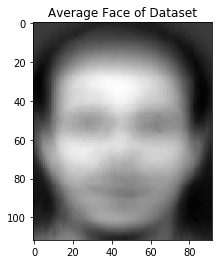

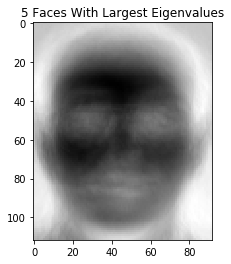

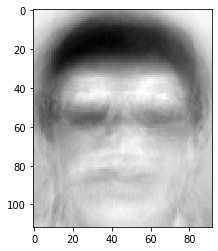

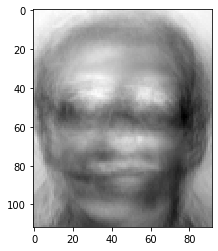

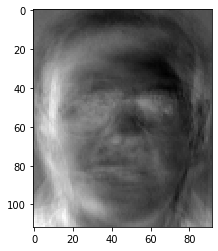

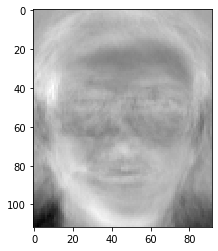

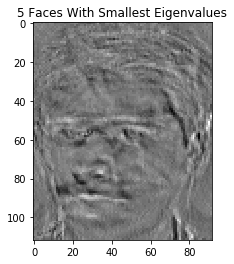

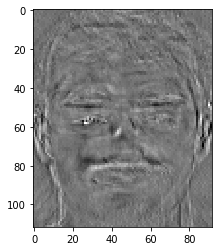

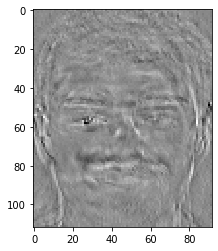

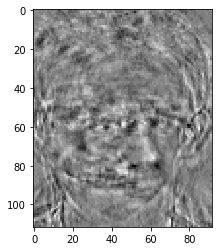

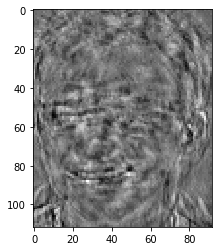

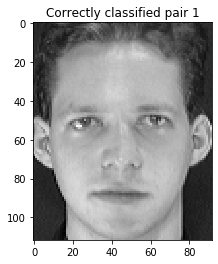

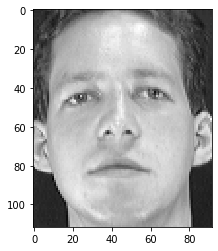

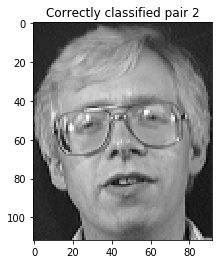

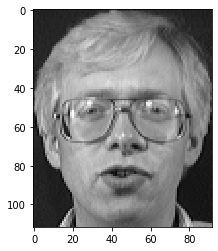

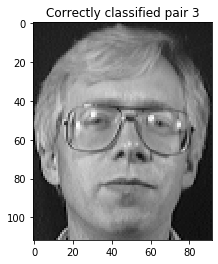

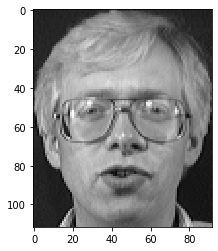

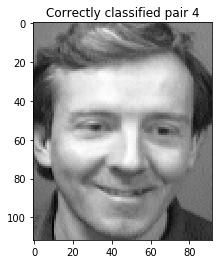

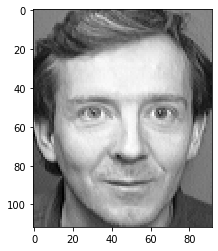

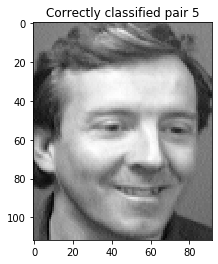

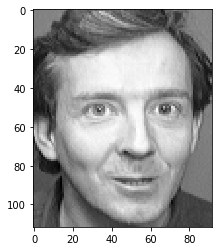

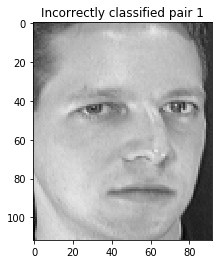

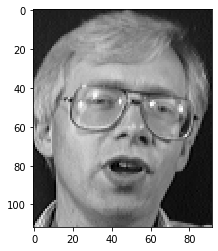

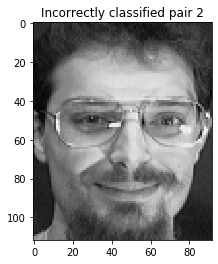

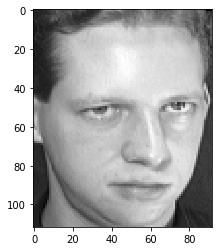

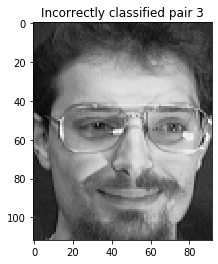

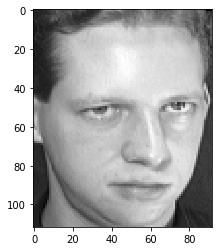

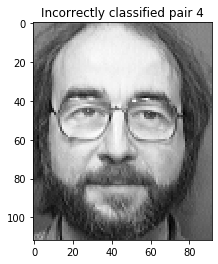

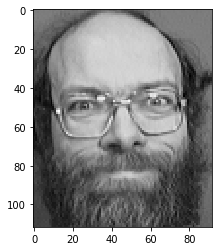

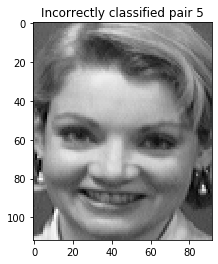

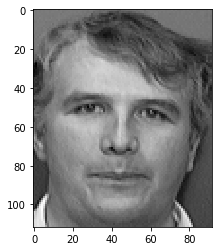

Percent of correct matches 91.25%


In [9]:
accuracy, E, eigenvalue, test_centered, gallery_centered = trial_1()

# Part B

In part B I choose different numbers of eigenvectors as the basis (5, 10, 20, 30, 40, 50). I then conduct the experiment for each basis with different number of eigenvectors, and compute the identification accuracy. I graphically show the curve of identification accuracy vs. the number of eigenvectors. 

In [10]:
# changing the size of the basis set (Part B)
# call function 6 times and put result inside pandas df
acc_1 = inference(E, eigenvalue, 5, test_centered, gallery_centered)
acc_2 = inference(E, eigenvalue, 10, test_centered, gallery_centered)
acc_3 = inference(E, eigenvalue, 20, test_centered, gallery_centered)
acc_4 = inference(E, eigenvalue, 30, test_centered, gallery_centered)
acc_5 = inference(E, eigenvalue, 40, test_centered, gallery_centered)
acc_6 = inference(E, eigenvalue, 50, test_centered, gallery_centered)

#show accuracy for (part B)
data = {'First 5 Cols':[acc_1[0]],'First 10 Cols':[acc_2[0]],
        'First 20 Cols':[acc_3[0]],'First 30 Cols':[acc_4[0]],
        'First 40 Cols':[acc_5[0]], 'First 50 Cols':[acc_6[0]]}

df = pd.DataFrame(data, index=['Percent correct'])

print("Accuracy for different size basis sets")
df

Accuracy for different size basis sets


,First 5 Cols,First 10 Cols,First 20 Cols,First 30 Cols,First 40 Cols,First 50 Cols
Percent correct,62.5,83.75,91.25,91.25,91.25,91.25


Text(0.5, 1.0, 'Basis Size Effecting Accuracy')

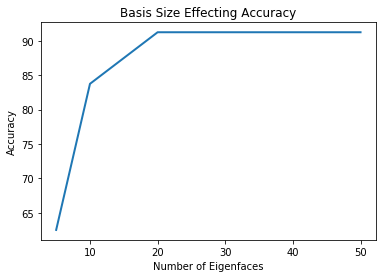

In [11]:
num_eigenfaces = [5, 10, 20, 30, 40, 50]
accuracy = list(data.values())
plt.plot(num_eigenfaces, accuracy, linewidth=2.0)
plt.ylabel('Accuracy')
plt.xlabel('Number of Eigenfaces')
plt.title('Basis Size Effecting Accuracy')

# Part C

I repeat part A to compute the PCA space for a specific split of the data. The training dataset consists of images 1.pgm, 2.pgm, 3.pgm, and 4.pgm, for all the individuals. The gallery dataset consists of images 5.pgm, 6.pgm, 7.pgm, and 8.pgm for all the individuals. The testing datasets consists of images 9.pgm and 10.pgm for all the individuals. I also include the aveage face of the dataset, the 5 eigenfaces corresponding to the 5 largest eigenvalues, and 5 eigenfaces corresponding to the 5 smallest eigenvalues. I also show 5 correctly classified images, 5 (if applicable) missclassified images, 2 random images, and percentage of correct matches.

In [12]:
def trial_2():

    #call functions 
    #reads in all images, takes no arguments since image folder is the same 
    image_array = readImages()
    #splitting index starts at 0 
    #thus 0 = 1.pgm, 2 = 3.pgm ... 
    test, train, gallery = splitData(image_array, 8, 0, 4)
    #normalize the dataset by mean-centering each dataset 
    test_centered, train_centered, gallery_centered = meanCenterData(test, train, gallery)
    #calculate correct eigenvectors 
    E, eigenvalue = eigenface(train_centered)
    
    #find the mean of the original image matrix to find the average face of the entire dataset
    average_face = np.mean(image_array, axis=1)
    average_face = np.reshape(average_face, (112,92)).astype(int)
    plt.imshow(average_face, cmap='gray')
    plt.title("Average Face of Dataset")
    plt.show()
    
    #show eigenvalue plots 
    eigenvaluePlots(E)

    #Compute main inference. Calculate accuracy for PCA
    acc_1, test, gallery = inference(E, eigenvalue, 50, test_centered, gallery_centered)
    
    inferencePlots(test, gallery)

    return acc_1

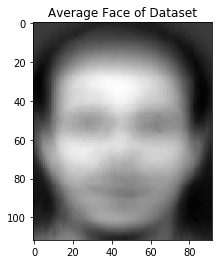

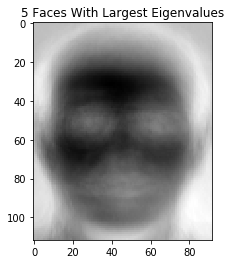

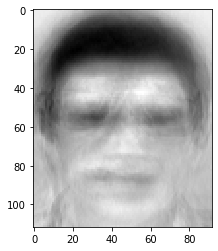

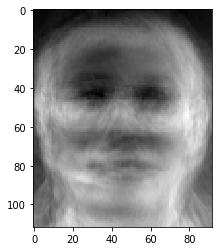

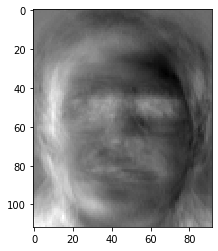

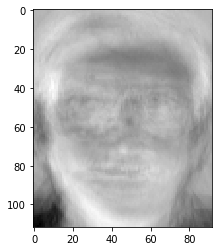

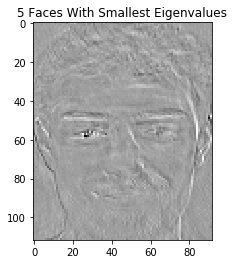

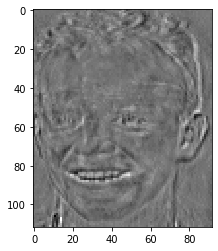

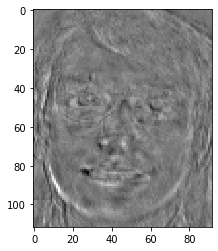

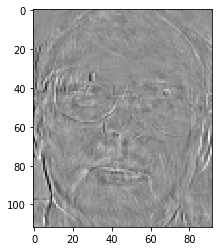

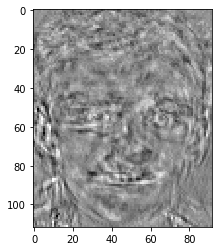

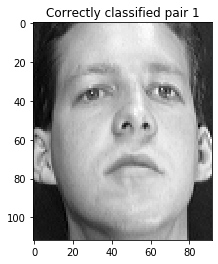

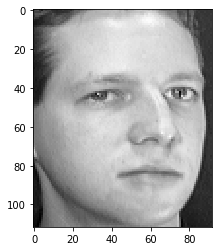

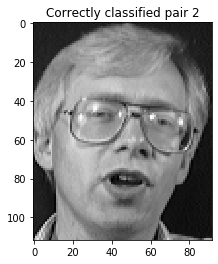

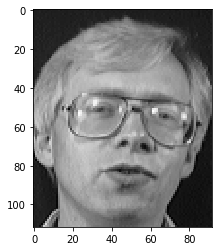

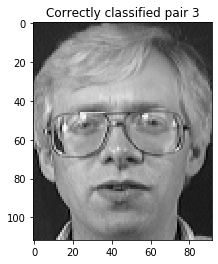

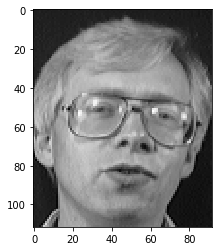

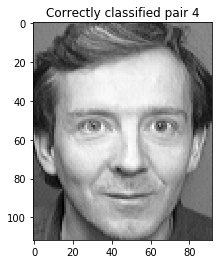

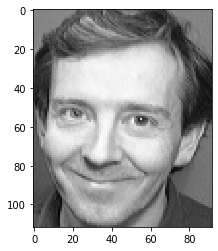

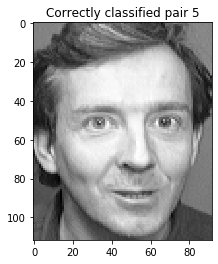

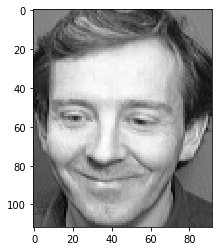

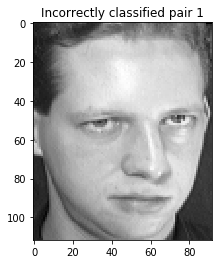

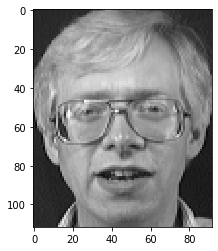

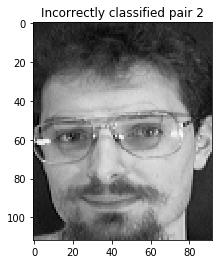

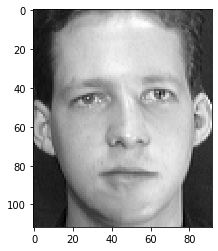

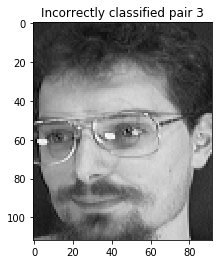

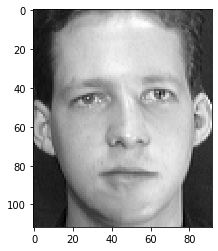

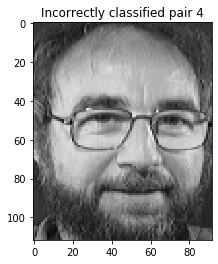

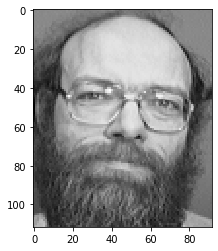

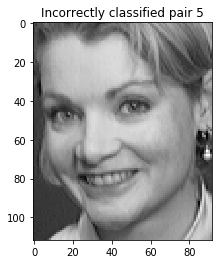

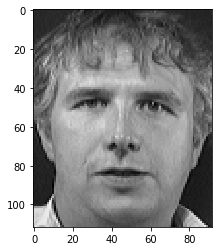

Percent of correct matches 91.25%


In [13]:
#call function for part C of lab
#Output plots and final accuracy
acc_1_c = trial_2()

#output accuracy for part C
print("Percent of correct matches {:.2f}%".format(acc_1_c))